In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_row",6000)
pd.set_option("display.max_column",200)
pd.set_option("display.precision", 2)

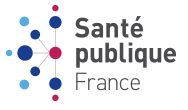

# <span class="bg-primary">Nettoyage du jeu de données<span>

# <span class="bg-danger">Introduction<span>
    
L'idée d'application dont nous testerons la faisabilité portera sur __l'alimentation en cas de diabète__. Notre application se voudra clairement informative et simple d'utilisation. Elle consistera à donner aux personnes diabétiques des informations sur les produits de la base de données d'_Open Food Facts_ les plus pertinentes possibles et les mieux adaptées au régime alimentaire préconisé aux diabétiques. 

# <span class="bg-danger">Sommaire<span>
    
__<span class="bg-info">1.<span>__ __Chargement__ du jeu de données
  
__<span class="bg-info">2.<span>__ __Informations générales__ sur le jeu de données
    
__<span class="bg-info">3.<span>__ __Nettoyage__ du jeu de données

__<span class="bg-warning">3_1.<span>__ __Valeurs manquantes__ par colonnes
___
__<span class="bg-warning">3_2.<span>__ __Doublons__ en ligne et colonnes redondantes
___
__<span class="bg-warning">3_3.<span>__ __Modification__ de certains noms de colonnes
___
__<span class="bg-warning">3_4.<span>__ __Sélection__ des colonnes utiles pour notre application
___
__<span class="bg-warning">3_5.<span>__ __Valeurs aberrantes__
___
__<span class="bg-info">4.<span>__ __Imputation__ avec KNNImputer de SKLearn

__<span class="bg-info">5.<span>__ __Feature engeenering__ création d'une nouvelle variable "ratio_sucre"

__<span class="bg-info">6.<span>__ __Bilan du nettoyage__    

__<span class="bg-info">7.<span>__ __Exportation__ de la base de données nettoyée   

## <span class="bg-info"> 1. Chargement du jeu de données<span>

In [3]:
data = pd.read_csv("openfoodfacts.csv",sep = '\t', low_memory=False )

## <span class="bg-info"> 2. Informations générales sur le jeu de données<span>

In [4]:
data.shape
print('Il y a {} lignes '.format(data.shape[0]) + 'et {} colonnes dans le jeu de données.'.format(data.shape[1]))

Il y a 220169 lignes et 181 colonnes dans le jeu de données.


In [5]:
data.head(3);

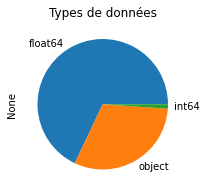

In [6]:
plt.figure(figsize=(6,3))
data.dtypes.value_counts().plot.pie()
plt.title("Types de données")
plt.show()

In [7]:
data.describe();

In [8]:
data.describe(exclude=[np.number]);

<AxesSubplot:>

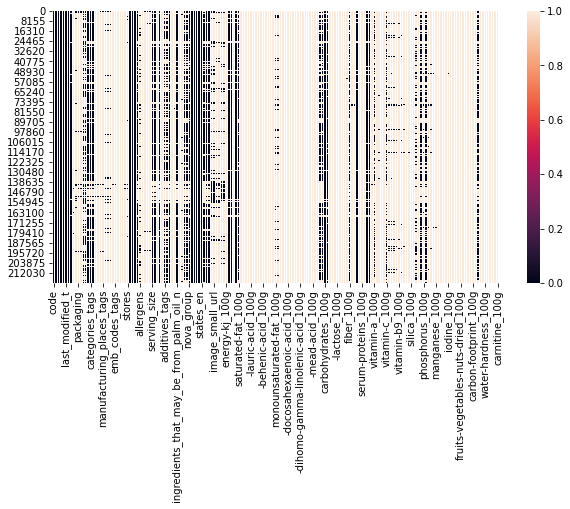

In [9]:
plt.figure(figsize=(10,5))
sns.heatmap(data.isna())

In [10]:
def get_missing_values(data):
    
    values = data.isnull().sum()
    percentage = 100 * data.isnull().sum() / len(data)
    table = pd.concat([values, percentage.round(2)], axis=1)
    table.columns = ['Nombre de valeurs manquantes', '% de valeurs manquantes']
    
    return table[table['Nombre de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending = False).style.background_gradient('Blues')

## <span class="bg-info"> 3. Nettoyage du jeu de données<span>

### <span class="bg-warning">3_1<span> Valeurs manquantes par colonnes

In [11]:
get_missing_values(data);

#### Suppression des colonnes entièrement vides

In [12]:
df = data.copy()

In [13]:
list(df.columns.values);

In [14]:
df = df.dropna(axis = 1, how = 'all')
df.shape
print('Il y a {} lignes '.format(df.shape[0]) + 'et {} colonnes dans le jeu de données.'.format(df.shape[1]))

Il y a 220169 lignes et 142 colonnes dans le jeu de données.


### <span class="bg-warning">3_2<span> Doublons en lignes et colonnes redondantes

Le __code__ est un identifiant propre à chaque produit. Son caractère unique va nous permettre de détecter les lignes redondantes si elles existent.

In [15]:
df.drop_duplicates( subset='code', keep='first', inplace=True)
df.shape
print('Il y a {} lignes '.format(df.shape[0]) + 'et {} colonnes dans le jeu de données.'.format(df.shape[1]))

Il y a 220169 lignes et 142 colonnes dans le jeu de données.


__Il n'y a pas de lignes doublons__ dans le jeu de données.

__Comparaison des colonnes qui semblent être redondantes__

In [16]:
#Fonction permettant de comparer les colonnes qui semblent être des doublons.
def compare_nan(df, col1, col2):
    num_rows, num_cols = df.shape
    
    col1notnull_col2null = round ( ( ( ( df[ (df[col1].notnull()) & ( df[col2].isna() ) ][[col1,col2]].shape[0] ) / num_rows ) * 100), 2)
    col2notnull_col1null = round ( ( ( ( df[ (df[col2].notnull()) & ( df[col1].isna() ) ][[col1,col2]].shape[0] ) / num_rows ) * 100), 2)
    col1notnull_col2notnull = round ( ( ( ( df[ (df[col1].notnull()) & ( df[col2].notnull() ) ][[col1,col2]].shape[0] ) / num_rows ) * 100), 2)
    
    print(f'Cas où {col1} est renseigné mais pas {col2} : {col1notnull_col2null}%')
    print(f'Cas où {col2} est renseigné mais pas {col1} : {col2notnull_col1null}%')
    print(f'Cas où {col1} et {col2} sont renseignés toutes les deux : {col1notnull_col2notnull}%')
    
compare_nan(df, 'categories','categories_tags')
compare_nan(df, 'categories','categories_en')
compare_nan(df, 'nutrition-score-fr_100g','nutriscore_score')
compare_nan(df, 'nutrition-score-fr_100g','nutriscore_grade')
compare_nan(df, 'countries','countries_tags')
compare_nan(df, 'countries','countries_en')

Cas où categories est renseigné mais pas categories_tags : 0.0%
Cas où categories_tags est renseigné mais pas categories : 0.0%
Cas où categories et categories_tags sont renseignés toutes les deux : 79.64%
Cas où categories est renseigné mais pas categories_en : 0.0%
Cas où categories_en est renseigné mais pas categories : 0.0%
Cas où categories et categories_en sont renseignés toutes les deux : 79.64%
Cas où nutrition-score-fr_100g est renseigné mais pas nutriscore_score : 0.0%
Cas où nutriscore_score est renseigné mais pas nutrition-score-fr_100g : 0.0%
Cas où nutrition-score-fr_100g et nutriscore_score sont renseignés toutes les deux : 64.76%
Cas où nutrition-score-fr_100g est renseigné mais pas nutriscore_grade : 0.0%
Cas où nutriscore_grade est renseigné mais pas nutrition-score-fr_100g : 0.0%
Cas où nutrition-score-fr_100g et nutriscore_grade sont renseignés toutes les deux : 64.76%
Cas où countries est renseigné mais pas countries_tags : 0.0%
Cas où countries_tags est renseigné 

Toutes les colonnes testées qui semblaient être des doublons en sont vraiment. Nous pourrons ne garder que l'une des deux.
Observons-le pour le nutriscore en comparant _nutrition-score-fr_100g_ et _nutriscore_score_ sur une dizaine d'exemples. 

In [17]:
def compare_cols(df, cols, sample=10):
    tmp = pd.DataFrame(columns=cols)
    for col in cols:
        tmp = pd.concat((tmp, df[~df[col].isna()][cols].sample(sample)))
    with pd.option_context('max_colwidth', 0):
        display(tmp)
compare_cols(df, ['nutrition-score-fr_100g','nutriscore_score'])

,nutrition-score-fr_100g,nutriscore_score
91277,-8.0,-8.0
109121,10.0,10.0
6671,4.0,4.0
110569,-2.0,-2.0
28455,15.0,15.0
127835,-4.0,-4.0
67202,13.0,13.0
108678,-5.0,-5.0
124832,11.0,11.0
38277,5.0,5.0


### <span class="bg-warning">3_3<span> Modification de certains noms de colonnes

Modification du nom de certaines colonnes (- remplacé par _ ) pour éviter des problèmes avec le code en python.

In [18]:
df.columns =df.columns.str.replace('-','_')
df.columns.to_list();

### <span class="bg-warning">3_4<span> __Elimination__ des colonnes inutiles pour l'application

__Sélection des colonnes utiles concernant l'alimentation.__

Notre application aura besoin de données sur une alimentation saine et équilibrée et devra donner des indications sur les apports en glucides des produits. Pour faire une sélection en fonction de la pertinence des informations mais aussi des données disponibles pour informer, nous allons explorer le dataframe dans sa partie "alimentation". 

In [19]:
list(df.columns.values);

In [20]:
data_alimentation = df.loc[:, ['allergens','traces','traces_tags','traces_en','additives_n','additives_tags','additives_en','ingredients_from_palm_oil_n','ingredients_from_palm_oil_tags','ingredients_that_may_be_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_tags','nutriscore_score','nutriscore_grade','nova_group','pnns_groups_1','pnns_groups_2','energy_kj_100g','energy_kcal_100g','energy_100g','energy_from_fat_100g','fat_100g','saturated_fat_100g','_butyric_acid_100g','_arachidic_acid_100g','_behenic_acid_100g','_cerotic_acid_100g','monounsaturated_fat_100g','polyunsaturated_fat_100g','omega_3_fat_100g','_alpha_linolenic_acid_100g','_eicosapentaenoic_acid_100g','_docosahexaenoic_acid_100g','omega_6_fat_100g','_linoleic_acid_100g','_arachidonic_acid_100g','trans_fat_100g','cholesterol_100g','carbohydrates_100g','sugars_100g','_sucrose_100g','_lactose_100g','starch_100g','polyols_100g','fiber_100g','_soluble_fiber_100g','_insoluble_fiber_100g','proteins_100g','serum_proteins_100g','nucleotides_100g','salt_100g','sodium_100g','alcohol_100g','vitamin_a_100g','vitamin_d_100g','vitamin_e_100g','vitamin_k_100g','vitamin_c_100g','vitamin_b1_100g','vitamin_b2_100g','vitamin_pp_100g','vitamin_b6_100g','vitamin_b9_100g','folates_100g','vitamin_b12_100g','biotin_100g','pantothenic_acid_100g','bicarbonate_100g','potassium_100g','chloride_100g','calcium_100g','phosphorus_100g','iron_100g','magnesium_100g','zinc_100g','nutrition_score_fr_100g','fruits_vegetables_nuts_100g','fruits_vegetables_nuts_dried_100g','fruits_vegetables_nuts_estimate_100g']]

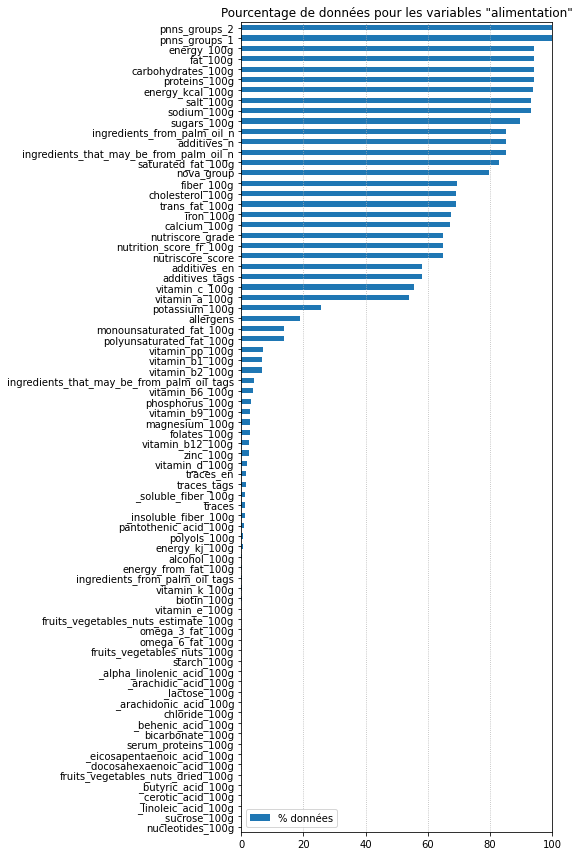

In [21]:
pourcentage_donnees_colonnes = pd.DataFrame(data=(data_alimentation.notnull().sum(axis=0).divide(len(df)).multiply(100).sort_values()),columns=['% données'])

pourcentage_donnees_colonnes.plot(kind='barh', figsize=(8, 12), xlim=(0, 100), 
                      title='Pourcentage de données pour les variables "alimentation"')
plt.grid(True, axis='x', linestyle=':')
plt.tight_layout()

Nous l'avions vu précedemment, mais beaucoup de colonnes "alimentation" ne sont pas renseignées et donc inexploitables. Parmi celles hautement pertinentes pour notre application, et bien renseignées, nous pouvons opérer une sélection:

__Alimentation saine__ : colonnes "nutrition_score_fr_100g", colonne "Nova"

__Pour le contrôle des apports en glucides__ : colonnes 'carbohydrates_100g','sugars_100g','fiber_100g',
'-soluble-fiber_100g','-insoluble-fiber_100g'

In [22]:
data_alimentation_diabete = df.loc[:, ['nutrition_score_fr_100g','nutriscore_grade','nova_group','carbohydrates_100g','sugars_100g','fiber_100g','_soluble_fiber_100g','_insoluble_fiber_100g']]

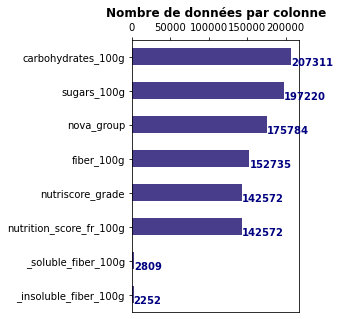

In [23]:
val_manquantes = data_alimentation_diabete.count()
val_manquantes.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(3,5))
val_manquantes.plot.barh(ax=ax, color='darkslateblue')
plt.gca().invert_yaxis()
ax.set_title("Nombre de données par colonne", fontweight='bold')
ax.xaxis.tick_top()
for i, v in enumerate(val_manquantes):
    ax.text(v + 3, i + .25, str(v), color='navy', fontweight='bold')

Peu de données pour différencier les fibres_solubles et insolubles. Peu de données disponibles donc colonnes peu exploitables. 

Nous ne les éliminerons après les avoir utilisées pour détecter des valeurs aberrantes.

In [24]:
data_alimentation_diabete = df.loc[:, ['nutrition_score_fr_100g','nutriscore_grade','nova_group','carbohydrates_100g','sugars_100g','fiber_100g', '_soluble_fiber_100g','_insoluble_fiber_100g']]

In [25]:
data_alimentation_diabete.describe();

__Valeurs aberrantes__ dont il faudra s'occuper pour les colonnes "carbohydrates_100g"(max > 100g), "sugars_100" (max > 100g) et "fiber_100g" (min < 0 ; max > 100g)

Beaucoup d'outliers. Il faudra s'en occuper. Nous visualisons une autre abérration : __certaines données dépassent 100g !__ Ce qui est impossible puisque toutes nos données "glucides" sont mesurées pour 100g.

__Sélection des colonnes utiles concernant les informations générales sur les produits (url, nom, photo...)__
Nous allons garder les colonnes qui permettent d'obtenir des informations sur les produits utiles à un utilsateur de notre application:
- __le nom__ du produit est évidemment essentiel,
- __une photo__ du produit facilite la reconnaissance, en particulier si l'utilisateur est un enfant,
- __le magasin__ où le produit a été acheté, cela pourra aider notre utilisateur à savoir où le produit est en vente, en particulier s'il s'agit d'une marque distributeur.
- __la catégorie__ (dessert, épicerie, boissons) peut éventuellement intéresser notre utilisateur.
- __le pays__ nous permettra éventuellement de filtrer la base en fonction du pays, donc de sélectionner une langue.

In [26]:
data_informations_generales = df.loc[:,['product_name','image_url','stores','categories', 'countries_tags']]

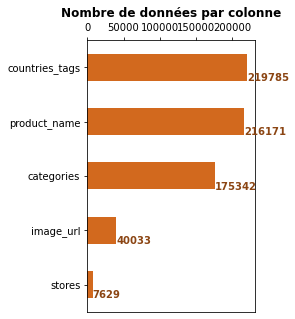

In [27]:
val_manquantes_infos = data_informations_generales.count()
val_manquantes_infos.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(3,5))
val_manquantes_infos.plot.barh(ax=ax, color='chocolate')
plt.gca().invert_yaxis()
ax.set_title("Nombre de données par colonne", fontweight='bold')
ax.xaxis.tick_top()
for i, v in enumerate(val_manquantes_infos):
    ax.text(v + 3, i + .25, str(v), color='saddlebrown', fontweight='bold')

In [28]:
data_informations_generales = df.loc[:,['product_name','categories','image_url','stores','countries_tags']]

__Dataframe contenant toutes les colonnes jugées utiles__

In [29]:
data_application_diabete = pd.concat([data_informations_generales, data_alimentation_diabete], axis = 1)
data_application_diabete.shape

(220169, 13)

In [30]:
get_missing_values(data_application_diabete)

,Nombre de valeurs manquantes,% de valeurs manquantes
_insoluble_fiber_100g,217917,98.98
_soluble_fiber_100g,217360,98.72
stores,212540,96.53
image_url,180136,81.82
nutrition_score_fr_100g,77597,35.24
nutriscore_grade,77597,35.24
fiber_100g,67434,30.63
categories,44827,20.36
nova_group,44385,20.16
sugars_100g,22949,10.42


Il y a des valeurs manquantes dans la colonne "product name", nous éliminons les lignes correspondantes, car l'information "nom du produit" est capitale.
__Suppression des lignes "product name" non renseignées.__

In [31]:
data_application_diabete = data_application_diabete.dropna(subset=['product_name'])
data_application_diabete.shape

(216171, 13)

Index(['product_name', 'categories', 'image_url', 'stores', 'countries_tags',
       'nutrition_score_fr_100g', 'nutriscore_grade', 'nova_group',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       '_soluble_fiber_100g', '_insoluble_fiber_100g'],
      dtype='object')

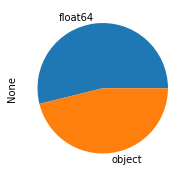

In [32]:
plt.figure(figsize=(5,3))
data_application_diabete.dtypes.value_counts().plot.pie()
data_application_diabete.columns

### <span class="bg-warning">3_6<span> Valeurs aberrantes

In [33]:
# Fonction qui supprime les valeurs aberrantes pour les colonnes _100g
def aberrant_100g(valeur):
    if valeur < 0 or valeur > 100:
        return np.NaN
    else:
        return valeur   
# Liste des colonnes intéressantes dont le nom se termine par "_100g"
liste_col = ['carbohydrates_100g','sugars_100g','fiber_100g']
for col in liste_col:
    data_application_diabete[col] = [aberrant_100g(val) for val in data_application_diabete[col]]

In [34]:
data_application_diabete.describe()

,nutrition_score_fr_100g,nova_group,carbohydrates_100g,sugars_100g,fiber_100g,_soluble_fiber_100g,_insoluble_fiber_100g
count,142476.00,175509.00,206984.00,196966.00,152555.00,2799.00,2247.00
mean,9.17,3.51,33.05,15.79,2.58,2.13,3.79
std,9.18,0.92,29.68,21.29,4.14,2.94,4.36
min,-14.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,3.00,6.60,1.19,0.00,0.00,0.00
50%,11.00,4.00,21.84,5.60,1.40,2.00,2.00
75%,16.00,4.00,60.47,23.33,3.60,3.00,6.00
max,36.00,4.00,100.00,100.00,100.00,61.00,34.00


Les valeurs aberrantes découvertes précédemment ont été supprimées pour les colonnes _100g.

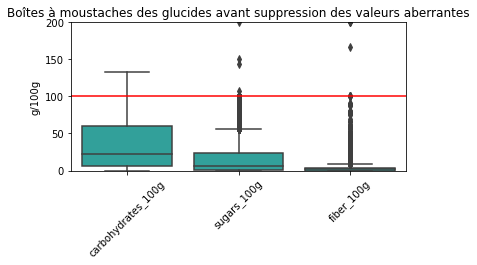

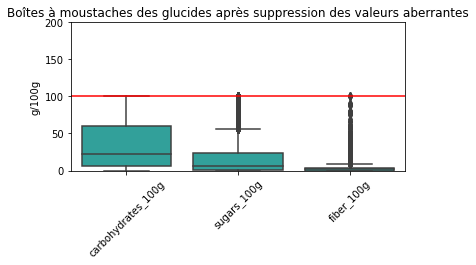

In [35]:
data_glucides = data.loc[:, ['carbohydrates_100g','sugars_100g','fiber_100g']]
data_glucides_sans_aberrant = data_application_diabete.loc[:, ['carbohydrates_100g','sugars_100g','fiber_100g']]
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
sns.boxplot(data=data_glucides, color="lightseagreen")
plt.title("Boîtes à moustaches des glucides avant suppression des valeurs aberrantes")
plt.ylim([0,200])
plt.xlabel("")
plt.ylabel("g/100g")
plt.xticks(rotation = 45);
plt.axhline(y=100, color ='r') 
plt.show()
plt.figure(figsize=(6,6))
plt.subplot(2,1,2)
sns.boxplot(data=data_glucides_sans_aberrant, color="lightseagreen")
plt.title("Boîtes à moustaches des glucides après suppression des valeurs aberrantes")
plt.ylim([0,200])
plt.xlabel("")
plt.ylabel("g/100g")
plt.xticks(rotation = 45);
plt.axhline(y=100, color ='r') 
plt.show()

__Supprimons les valeurs aberrantes pour lesquelles la masse totale des glucides pour 100 g est inférieure à la masse de sucre.__

In [36]:
data_application_diabete = data_application_diabete.drop(data_application_diabete[data_application_diabete["carbohydrates_100g"]< data_application_diabete["sugars_100g"]].index)

In [37]:
data_application_diabete.shape

(215939, 13)

__Supprimons de même les valeurs aberrantes pour lesquelles la masse totale des fibres pour 100 g est inférieure à la masse d'une des deux types de fibres (soluble ou insoluble) prise séparément.__

In [38]:
data_application_diabete = data_application_diabete.drop(data_application_diabete[(data_application_diabete["fiber_100g"] < data_application_diabete["_soluble_fiber_100g"]) | (data_application_diabete["fiber_100g"] < data_application_diabete["_insoluble_fiber_100g"])].index)

In [39]:
data_application_diabete = data_application_diabete.drop(['_soluble_fiber_100g','_insoluble_fiber_100g'], axis = 1)

In [40]:
data_application_diabete.shape

(215752, 11)

__Supprimons les lignes pour lesquelles nous avons peu de données renseignées.__

Nous décidons de ne garder que les lignes bien renseignées du jeu de données. (7 informations sur 9)
Notre application donnera des conseils utiles à la santé des personnes diabétiques. Nous aurons besoin de créer un score pour classer les produits du + au - appropriés. Tous les champs permettant de calculer le score doivent être renseignés. Nous serons donc obligés de faire de l'imputation. 

In [41]:
data_application_diabete = data_application_diabete.dropna(thresh = 8)

In [42]:
data_application_diabete.shape

(142612, 11)

In [43]:
get_missing_values(data_application_diabete)

,Nombre de valeurs manquantes,% de valeurs manquantes
stores,137402,96.35
image_url,130388,91.43
nova_group,7831,5.49
fiber_100g,7630,5.35
nutrition_score_fr_100g,622,0.44
nutriscore_grade,622,0.44
categories,179,0.13
carbohydrates_100g,22,0.02
countries_tags,19,0.01
sugars_100g,8,0.01


In [44]:
data_application_diabete.columns;

<AxesSubplot:>

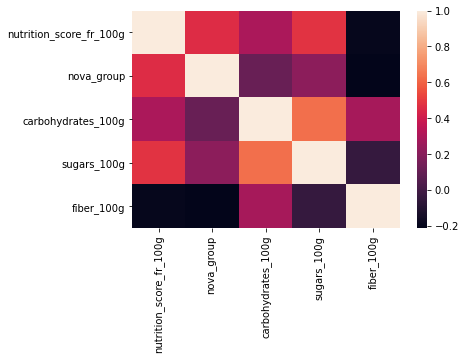

In [45]:
col_to_keep = ['nutrition_score_fr_100g', 'nova_group', 'carbohydrates_100g','sugars_100g', 'fiber_100g']
sns.heatmap(data_application_diabete[col_to_keep].corr())

## <span class="bg-info"> 4. Imputation avec SciKitLearn<span> 

Vérification de la taille du jeu de données

In [46]:
data_application_diabete.columns

Index(['product_name', 'categories', 'image_url', 'stores', 'countries_tags',
       'nutrition_score_fr_100g', 'nutriscore_grade', 'nova_group',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g'],
      dtype='object')

#### Supprimons toutes les valeurs manquantes afin d'entrainer un model de ML et de trouver le meilleur "n_neighbors"
_Nouveau dataframe créé pour l'entraînement, nous gardons uniquement les 5 premières colonnes avant de supprimer les NAN, car les 2 dernières colonnes ont beaucoup de NAN_

In [47]:
data_application_diabete_sans_NAN = data_application_diabete.iloc[:,5:13].dropna(axis=0,how='any',thresh=None,subset=None,inplace=False)

In [48]:
data_application_diabete_sans_NAN.columns

Index(['nutrition_score_fr_100g', 'nutriscore_grade', 'nova_group',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g'],
      dtype='object')

In [49]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

#### Création du train_set et du test_set

In [50]:
X = data_application_diabete_sans_NAN[['nutrition_score_fr_100g', 'carbohydrates_100g','sugars_100g','fiber_100g']]
y = data_application_diabete_sans_NAN['nova_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Création d'un pipeline

In [51]:
model = make_pipeline(KNNImputer(),RandomForestRegressor())

params = {'knnimputer__n_neighbors' : [1, 2, 3, 4]}

grid = GridSearchCV(model, param_grid=params, cv=5)

grid.fit(X_train, y_train)
grid.best_params_

{'knnimputer__n_neighbors': 3}

#### Imputation avec KNNImputer de SKLearn

In [52]:
imputer = KNNImputer(n_neighbors=1)
data_application_diabete_smart = pd.DataFrame(imputer.fit_transform(data_application_diabete[col_to_keep]),columns = data_application_diabete[col_to_keep].columns)

In [53]:
data_application_diabete.drop(['nutrition_score_fr_100g', 'nova_group', 'carbohydrates_100g','sugars_100g', 'fiber_100g'], axis = 1, inplace = True)
data_application_diabete

,product_name,categories,image_url,stores,countries_tags,nutriscore_grade
3,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",https://static.openfoodfacts.org/images/produc...,courte paille,en:france,d
13,Salade de carottes râpées,"Plats préparés, Légumes préparés, Carottes râp...",https://static.openfoodfacts.org/images/produc...,NaN,en:france,b
21,Tarte noix de coco,"Tartes, Tartes sucrées, Tartes à la noix de coco",https://static.openfoodfacts.org/images/produc...,NaN,en:france,d
31,Compote de poire,"Aliments et boissons à base de végétaux, Alime...",https://static.openfoodfacts.org/images/produc...,NaN,en:france,a
35,Salade de macedoine de légumes,"Plats préparés, Légumes préparés, Entrées, Ent...",https://static.openfoodfacts.org/images/produc...,NaN,en:france,b
...,...,...,...,...,...,...
220163,Reduced fat ice cream bar,"Desserts, Frozen foods, Frozen desserts",NaN,NaN,en:united-states,d
220164,Low Fat Frozen Yogurt Bar,"Dairies, Desserts, Fermented foods, Fermented ...",NaN,NaN,en:united-states,c
220165,Low Fat Froze Yogurt Bar,"Dairies, Desserts, Fermented foods, Fermented ...",NaN,NaN,en:united-states,c
220166,Low Fat Frozen Yogurt Bar,"Dairies, Desserts, Fermented foods, Fermented ...",NaN,NaN,en:united-states,c


In [54]:
data_application_diabete_smart["index"] = range(0, len(data_application_diabete_smart))
data_application_diabete["index"] = range(0, len(data_application_diabete))

In [55]:
data_application_smart = data_application_diabete.merge(data_application_diabete_smart, left_on = 'index', right_on = 'index')[['product_name', 'categories','image_url','stores','countries_tags','nutriscore_grade','nutrition_score_fr_100g','nova_group','carbohydrates_100g','sugars_100g','fiber_100g']]

In [56]:
data_application_smart[['nutrition_score_fr_100g', 'nova_group']] = data_application_smart[['nutrition_score_fr_100g', 'nova_group']].apply(np.ceil)

In [57]:
data_application_smart = data_application_smart.dropna(subset=['nutriscore_grade'])

## <span class="bg-info"> 5. Feature engeeniring : création d'une nouvelle variable "ratio_sucre"<span> 

Il est important pour un diabétique de calculer ses apports en sucres rapides (simples), nommés "sucre" sur les étiquettes alimentaires par rapport à la masse des glucides.
Pour calculer le pourcentage de sucres rapides, nous créons une nouvelle variable : "% sucres". 

Pour la calculer : __(sucres rapides = "sugars_100g) / (Glucides total="carbohydrates_100g") * 100__
Plus le pourcentage est élevé, plus le produit est à déconseiller à une personne diabétique.

In [58]:
def pourcentage_sucre(row):
    if row['carbohydrates_100g']!= 0 :  
        return (row['sugars_100g'] / row['carbohydrates_100g'])*100
    else:
        return 100
            
data_application_smart["ratio_sucre"] = data_application_smart.apply(pourcentage_sucre, axis=1)

In [59]:
data_application_smart.head(100);

<AxesSubplot:>

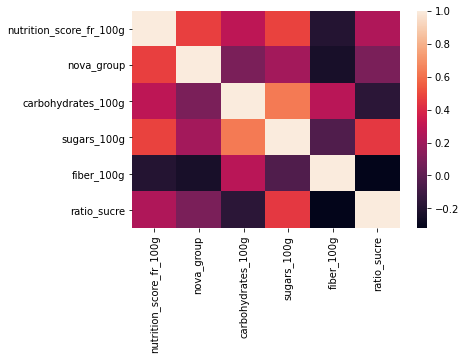

In [60]:
col_to_keep = ['nutrition_score_fr_100g', 'nova_group', 'carbohydrates_100g','sugars_100g', 'fiber_100g',"ratio_sucre"]
sns.heatmap(data_application_smart[col_to_keep].corr())

## <span class="bg-info"> 6. Bilan du nettoyage<span> 

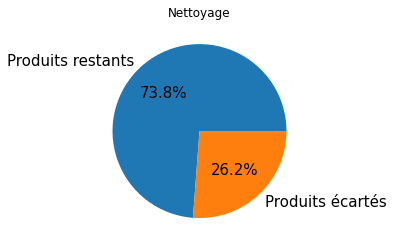

In [61]:
nettoyage = pd.DataFrame({'Products count': [data.shape[0], data.shape[0]-data_application_smart.shape[0]]},index=['Produits restants', 'Produits écartés'])
plot = nettoyage.plot.pie(y='Products count', figsize=(4,4), autopct='%1.1f%%', title = 'Nettoyage', fontsize=15, legend = False)
plot = plt.ylabel('')

In [62]:
data_application_smart.shape

(141990, 12)

In [63]:
data_application_smart.columns

Index(['product_name', 'categories', 'image_url', 'stores', 'countries_tags',
       'nutriscore_grade', 'nutrition_score_fr_100g', 'nova_group',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'ratio_sucre'],
      dtype='object')

<AxesSubplot:>

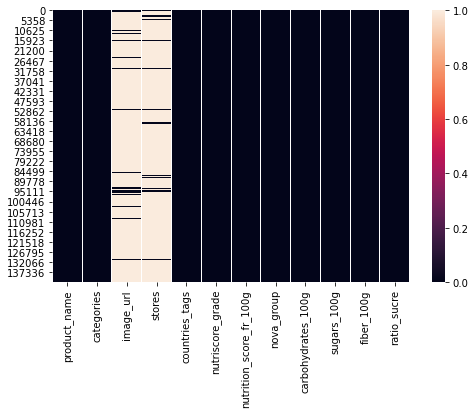

In [64]:
plt.figure(figsize=(8,5))
sns.heatmap(data_application_smart.isna())

## <span class="bg-info"> 7. Exportation de la base de données nettoyée<span> 

In [65]:
data_application_smart.to_csv('data_application_smart.csv',sep = '\t', encoding='utf_8', index=False)